# Raport o danych - V3

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import csv

In [3]:
DIR_DATA = 'data/v3'

In [4]:
artists = pd.read_json(path_or_buf=f'{DIR_DATA}/artists.jsonl', lines=True)
# sessions = pd.read_json(path_or_buf=f'{DIR_DATA}/sessions.jsonl', lines=True)
sessions = pd.read_csv(f'{DIR_DATA}/sessions.csv')
tracks = pd.read_json(path_or_buf=f'{DIR_DATA}/tracks.jsonl', lines=True)
users = pd.read_json(path_or_buf=f'{DIR_DATA}/users.jsonl', lines=True)

## Artists

In [5]:
artists.head()

,id,name,genres
0,7jVv8c5Fj3E9VhNjxT4snq,Lil Nas X,"[country rap, lgbtq+ hip hop, pop rap, queer c..."
1,0xRXCcSX89eobfrshSVdyu,MEDUZA,"[dance pop, edm, pop dance, pop house, tropica..."
2,3OKg7YbOIatODzkRIbLJR4,TheFatRat,[speedrun]
3,4f7KfxeHq9BiylGmyXepGt,Tanishk Bagchi,"[desi pop, filmi, modern bollywood]"
4,56mfhUDKa1vec6rSLZV5Eg,Jawsh 685,[nz pop]


In [6]:
non_unique_ids = artists['id'].value_counts().loc[lambda x: x > 1]
print(non_unique_ids)

Series([], Name: id, dtype: int64)


Brak błędnych wartości id.

In [7]:
artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1667 entries, 0 to 1666
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1667 non-null   object
 1   name    1667 non-null   object
 2   genres  1667 non-null   object
dtypes: object(3)
memory usage: 39.2+ KB


In [8]:
artists.isnull().sum()

id        0
name      0
genres    0
dtype: int64

Ilość artystów nie zmieniła się.

In [9]:
unique_artists = tracks['id_artist'].nunique()
print(f"The number of unique artists in the tracks table is: {unique_artists}")

The number of unique artists in the tracks table is: 1418


Nie wszyscy artyści posiadają utwory w obecnie posiadanych danych. <br>
Jest to jednak właściwość danych potwierdzona przez klienta.

## Sessions

In [10]:
sessions.head()

,session_id,timestamp,user_id,track_id,event_type
0,124,2023-10-27T23:50:02.941000,101,NaN,advertisment
1,124,2023-10-27T23:50:02.941000,101,0qbV4e18lWrTTxlswVoLbI,like
2,124,2023-10-27T23:50:11.212000,101,0qbV4e18lWrTTxlswVoLbI,skip
3,124,2023-10-27T23:50:16.212000,101,3pyTksNccLM1jRvzQ4zTke,play
4,124,2023-10-27T23:53:25.799000,101,5y3f0HzXlMbge94XeyEFiV,play


In [11]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5773704 entries, 0 to 5773703
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   session_id  int64 
 1   timestamp   object
 2   user_id     int64 
 3   track_id    object
 4   event_type  object
dtypes: int64(2), object(3)
memory usage: 220.2+ MB


Ilość sesji znów wzrosła drastycznie.

In [12]:
sessions.isnull().sum()

session_id         0
timestamp          0
user_id            0
track_id      786597
event_type         0
dtype: int64

### Braki:

In [13]:
event_types = sessions['event_type'].unique() 
event_types = event_types[~pd.isnull(event_types)]

for event_type in event_types:
    missing_track_id_for_event_type = len(sessions[(sessions['event_type'] == event_type) & (sessions['track_id'].isnull())])
    print(f"Liczba brakujących track_id gdy event_type = '{event_type}': {missing_track_id_for_event_type}")

Liczba brakujących track_id gdy event_type = 'advertisment': 786597
Liczba brakujących track_id gdy event_type = 'like': 0
Liczba brakujących track_id gdy event_type = 'skip': 0
Liczba brakujących track_id gdy event_type = 'play': 0


In [14]:
event_counts = sessions['event_type'].value_counts()
print(event_counts)

play            2981738
like            1526793
advertisment     786597
skip             478576
Name: event_type, dtype: int64


Wszystkie przypadki brakującego track_id są nadal dla zdarzenia typu advertisement. <br> 

### Rozkład event_type

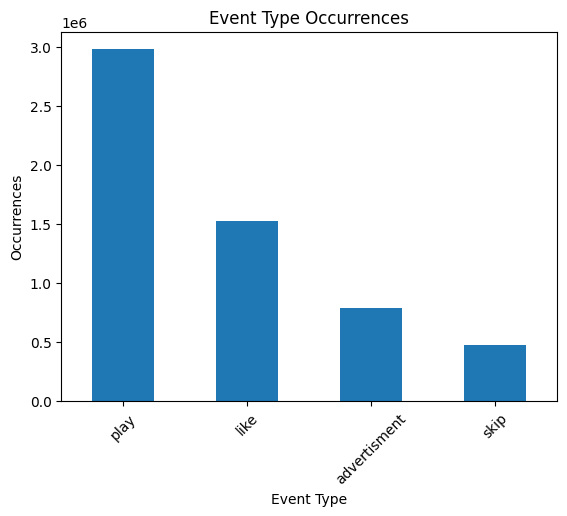

In [15]:
event_counts.plot(kind='bar')
plt.xlabel('Event Type')
plt.ylabel('Occurrences')
plt.title('Event Type Occurrences')
plt.xticks(rotation=45)
plt.show()


Rozkład typów zdarzeń jest niemal identyczny z poprzednim.

### Rozkład sesji w czasie

Minimum Timestamp: 2021-01-01 15:09:29.705000
Maximum Timestamp: 2024-01-02 09:35:01.325000
Number of weeks: 158


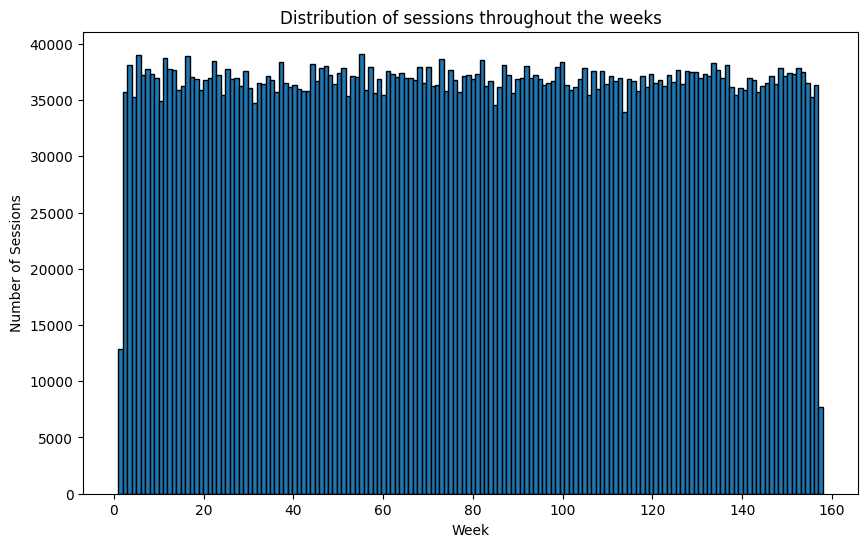

In [17]:
sessions['timestamp'] = pd.to_datetime(sessions['timestamp'])
sessions['week'] = sessions['timestamp'].dt.strftime('%U')

start_date = pd.to_datetime('2020-12-28')

sessions['week'] = (sessions['timestamp'] - start_date).dt.days // 7
sessions['week'] = sessions['week'] + 1

min_timestamp = sessions['timestamp'].min()
max_timestamp = sessions['timestamp'].max()

print(f"Minimum Timestamp: {min_timestamp}")
print(f"Maximum Timestamp: {max_timestamp}")

print(f"Number of weeks: {max(sessions['week']) - min(sessions['week']) + 1}")

plt.figure(figsize=(10, 6))
plt.hist(sessions['week'], bins=max(sessions['week']) - min(sessions['week']) + 1, edgecolor='black')
plt.title('Distribution of sessions throughout the weeks')
plt.xlabel('Week')
plt.ylabel('Number of Sessions')
plt.show()

W tym momencie dysponujemy danymi historycznymi z jednego roku. Pozwala to już na pewną analizę sezonowości i trendów rocznych. <br>
Sesje w każdym tygodniu roku rozłożone są dość równomiernie.

In [ ]:
unique_tracks = sessions['track_id'].nunique()
print(f"The number of unique tracks in the sessions table is: {unique_tracks}")

The number of unique tracks in the sessions table is: 12303


Możemy z tego wnioskować, że duża część utworów (ponad 10 tysięcy) nie ma w sesjach odnotowanej żadnej interakcji użytkowników. <br> 
Może to wskazywać na niepełne dane sesji lub może być również normalne - użytkownicy mogli nigdy nie trafić na niszowe utwory, <br>
zwłaszcza jeżeli platforma nie posiada algorytmu, który mógłby takie utwory promować.

## Tracks

In [ ]:
tracks.head()

,id,name,popularity,duration_ms,explicit,id_artist,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0RNxWy0PC3AyH4ThH3aGK6,Mack the Knife,55,201467,0,19eLuQmk9aCobbVDHc6eek,1929,0.673,0.3770,0,-14.141,0.0697,0.586,0.000000,0.332,0.713,88.973
1,2W889aLIKxULEefrleFBFI,Someone to Watch Over Me,54,198000,0,1Mxqyy3pSjf8kZZL4QVxS0,1943,0.204,0.1510,2,-17.842,0.0418,0.947,0.000009,0.321,0.134,91.783
2,4Pnzw1nLOpDNV6MKI5ueIR,Nancy (With the Laughing Face) - 78rpm Version,55,199000,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.295,0.0826,1,-19.569,0.0367,0.984,0.000358,0.156,0.169,128.600
3,7GLmfKOe5BfOXk7334DoKt,Saturday Night (Is The Loneliest Night In The ...,54,163000,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.561,0.3350,9,-11.093,0.0499,0.840,0.000002,0.788,0.590,126.974
4,6kD1SNGPkfX9LwaGd1FG92,Put Your Dreams Away (For Another Day),53,186173,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.197,0.0546,1,-22.411,0.0346,0.950,0.276000,0.152,0.100,90.150


In [ ]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22412 entries, 0 to 22411
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                22412 non-null  object 
 1   name              22412 non-null  object 
 2   popularity        22412 non-null  int64  
 3   duration_ms       22412 non-null  int64  
 4   explicit          22412 non-null  int64  
 5   id_artist         22412 non-null  object 
 6   release_date      22412 non-null  object 
 7   danceability      22412 non-null  float64
 8   energy            22412 non-null  float64
 9   key               22412 non-null  int64  
 10  loudness          22412 non-null  float64
 11  speechiness       22412 non-null  float64
 12  acousticness      22412 non-null  float64
 13  instrumentalness  22412 non-null  float64
 14  liveness          22412 non-null  float64
 15  valence           22412 non-null  float64
 16  tempo             22412 non-null  float6

Ilość utworów nie zmieniła się.

In [ ]:
tracks.isnull().sum()

id                  0
name                0
popularity          0
duration_ms         0
explicit            0
id_artist           0
release_date        0
danceability        0
energy              0
key                 0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
dtype: int64

Brakujące wartości atrybutów zostały naprawione.

### Rozkład atrybutów

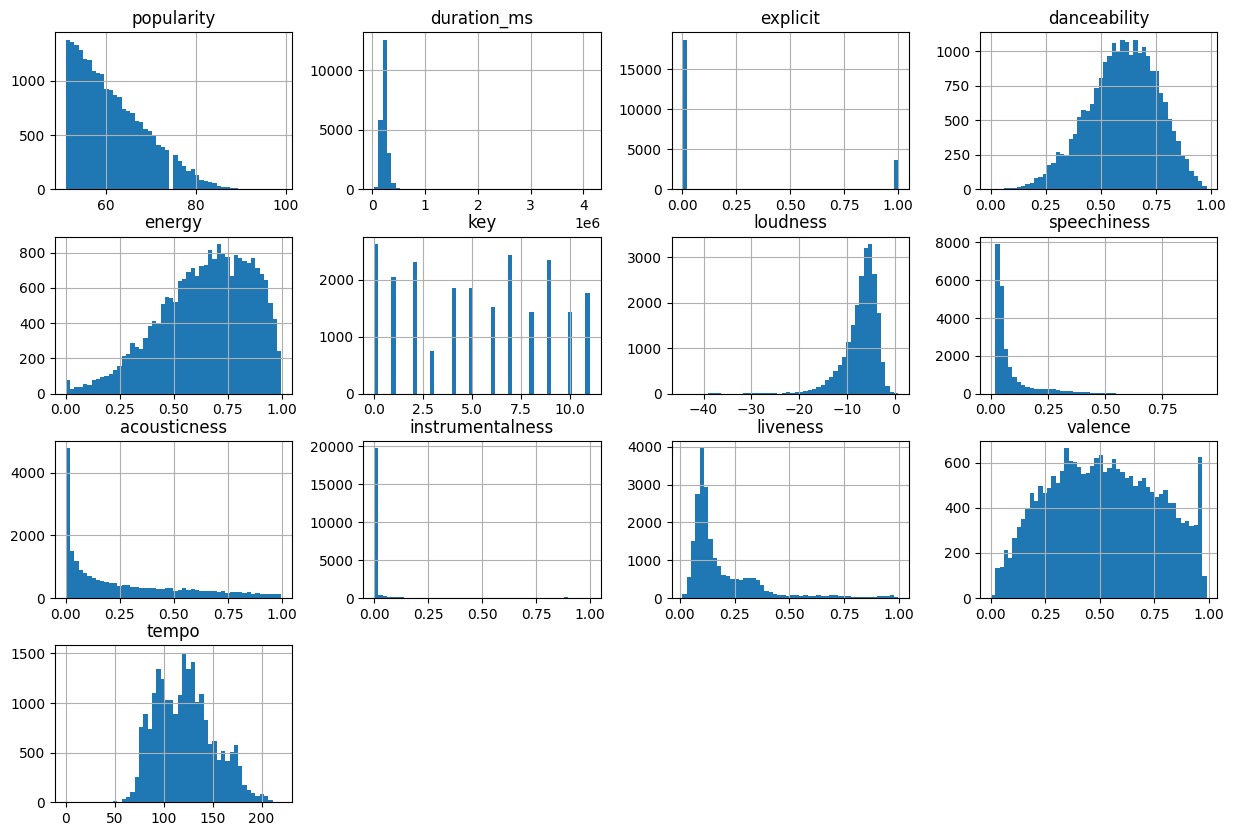

In [ ]:
tracks.hist(figsize=(15, 10), bins=50);

Rozkład poszczególnych atrybutów nie uległ znaczącej zmianie. <br>
Rozkład instrumentalness nadal jest mocno niezrównoważony, może to jednak wynikać ze specyfiki utworów na platformie.

## Users

In [ ]:
users.head()

,user_id,name,city,street,favourite_genres,premium_user
0,101,Dominik Paździora,Wrocław,aleja Jabłoniowa 55/02,"[dance pop, latin, hard rock]",False
1,102,Justyna Mszyca,Poznań,ul. Krótka 710,"[reggaeton, latin arena pop, modern rock]",False
2,103,Kornelia Witka,Gdynia,al. Kościuszki 587,"[rap, art rock, rock]",False
3,104,Jędrzej Kotala,Gdynia,pl. Kossaka 97/86,"[mexican pop, contemporary country, psychedeli...",False
4,105,Karol Kleban,Kraków,ul. Tulipanowa 861,"[rock, adult standards, permanent wave]",False


Atrybuty name, city, street są nadmiarowe, ponieważ są nieistotne z punktu widzenia zadania. <br>
Dodatkowo, stanowią potencjalny problem prywatności / bezpieczeństwa. <br>
Również premium_user nie wydaje się mieć znaczenia w przewidywaniu preferencji utworowych użytkowników.

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           5000 non-null   int64 
 1   name              5000 non-null   object
 2   city              5000 non-null   object
 3   street            5000 non-null   object
 4   favourite_genres  5000 non-null   object
 5   premium_user      5000 non-null   bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 200.3+ KB


Tabela users zawiera 1000 wpisów. Taka liczba może nie być wystarczająca do dokładnej reprezentacji użytkowników całego serwisu, a przede wszystkim, ich preferencji co do gatunków muzyki.

In [ ]:
users.isnull().sum()

user_id             0
name                0
city                0
street              0
favourite_genres    0
premium_user        0
dtype: int64

Nie wykryliśmy braków w żadnym z atrybutów.

In [ ]:
unique_users = sessions['user_id'].nunique()
print(f"The number of unique users in the sessions table is: {unique_users}")

The number of unique users in the sessions table is: 5000


Obecnie, wszystkie sesje są pokryte przez wszystkich użytkowników, co sugeruje że wszystkich użytkowników serwisu jest jedynie 1000. <br>
Oznaczałoby to że posiadamy dane całej populacji użytkowników.

### Rozkład favourite_genres

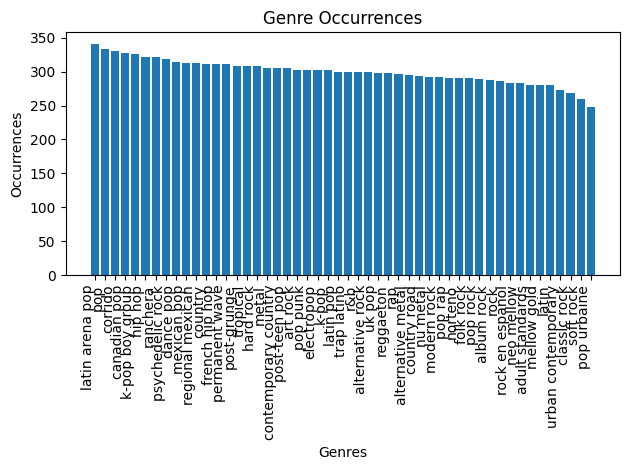

In [ ]:
genres = users['favourite_genres'].explode().value_counts().to_dict()

plt.bar(genres.keys(), genres.values())
plt.xlabel('Genres')
plt.ylabel('Occurrences')
plt.title('Genre Occurrences')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


## Podsumowanie:
- Ilość sesji wzrosła znacząco - powinna być wystarczająca dla naszego modelu. <br> Jeśli jednak jest dostępna ich większa ilość, to wpłynie ona pozytywnie na jakość prognoz.
- Większość błędów/braków w sesjach została naprawiona. <br> Jedyny (potencjalny) problem, który pozostał nierozwiązany to brak track_id dla każdego zdarzeń typu "adevrtisment", natomiast zdarzenia te nie niosą istotnych informacji w kontekście naszego modelu. @TODO zrewidować po napisaniu założeń
- Błędne wartości id artystów oraz brakujące wartości w ich gatunkach zostały naprawione. <br> Ilość artystów się nie zmieniła.
- Brakujące wartości atrybutów utworów zostały naprawione. Ilość utworów nie zmieniła się. <br> Biorąc pod uwagę, że nie każdy artysta ma przypisany utwór możemy nie mieć pełnej listy utworów, istnieje jednak możliwość, że jest to normalna właściwość tych danych.
- Tabela użytkowników zawiera atrybuty nieistotne z punktu widzenia zadania, a jednocześnie narażające klientów na potencjalny wyciek danych / problem z prywatnością. Również atrybut premium_user nie wydaje się mieć znaczenie w preferencjach muzycznych użytkowników. <br> W obecnie posiadanych danych, dane dotyczące sesji są pokryte przez wszystkich użytkowników, co sugeruje że posiadamy wszystkich użytkowników serwisu.

<br>

* Inicjalnie planowaliśmy wykorzystać zależności między ulubionymi gatunkami użytkowników a gatunkami artysty, którego utwór jest odtwarzany.
* Zależność taka nie jest jednak wystarczająco prezycyjna by uznać ją za użyteczną. (Lepiej byłoby, gdyby to sam utwór miał przypisany gatunek).
* Oznacza to, że tabele users i artists są niepotrzebne. Zdecydowaliśmy się z nich nie korzystać.